In [1]:
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

In [4]:
data = pd.read_csv("../NullValueHandled/KurunegalaProperHandledNullValues.csv", index_col=0, parse_dates=True)

In [5]:
data.head()

,Next Date,HCHO reading
Current Date,,
2019-01-01,2019-01-02,0.000088
2019-01-02,2019-01-03,0.000137
2019-01-03,2019-01-04,0.000148
2019-01-04,2019-01-05,-0.000002
2019-01-05,2019-01-06,0.000249


In [6]:
kurunegala_data = data[["HCHO reading"]]
kurunegala_data.head()   

,HCHO reading
Current Date,
2019-01-01,0.000088
2019-01-02,0.000137
2019-01-03,0.000148
2019-01-04,-0.000002
2019-01-05,0.000249


In [7]:
kurunegala_data.shape  

(1826, 1)

In [8]:
X = kurunegala_data.values  

#### This looks like that Kurunegala fomaldihyde rates have a seasonality

<Axes: xlabel='Current Date'>

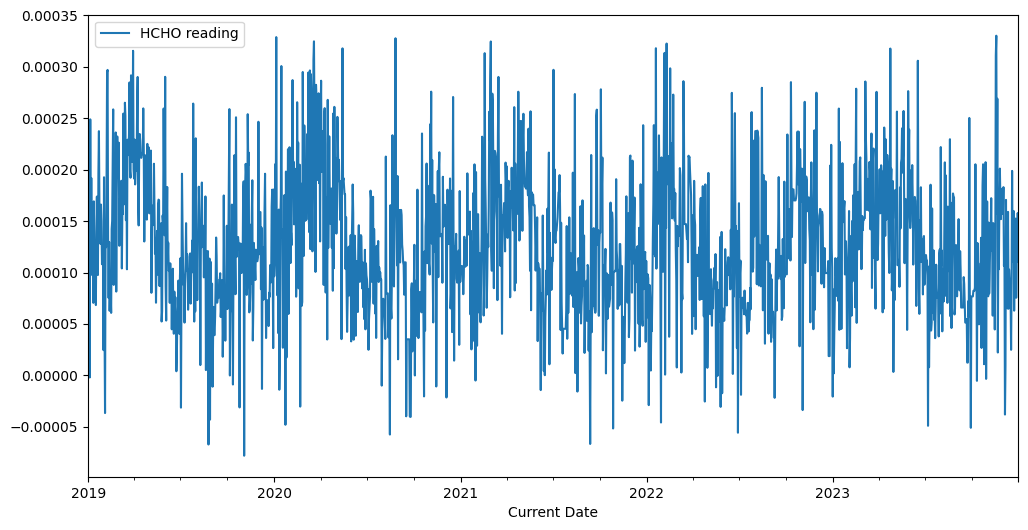

In [10]:
kurunegala_data.plot(figsize=(12, 6)) 

In [11]:
from statsmodels.tsa.stattools import adfuller

In [13]:
test_kurunegala = adfuller(kurunegala_data["HCHO reading"], autolag="AIC") 

In [14]:
print("ADF value : ", test_kurunegala[0])
print("P value: ", test_kurunegala[1])
print("Num of Lags :", test_kurunegala[2])
print("Num of Observations used for ADF Regression and Critical Calculation :", test_kurunegala[3])
for key, val in test_kurunegala[4].items():
    print("\t", key, ": ", val)

ADF value :  -5.850232148878149
P value:  3.603706776152739e-07
Num of Lags : 10
Num of Observations used for ADF Regression and Critical Calculation : 1815
	 1% :  -3.4339580289794225
	 5% :  -2.8631337437669275
	 10% :  -2.567618456010139


#### Auto correlation and correlation plot for Kurunegala

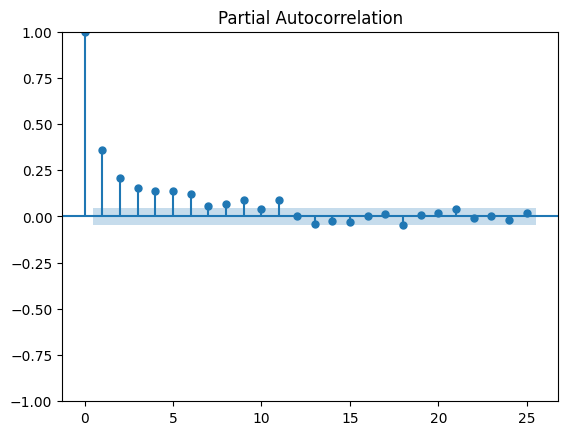

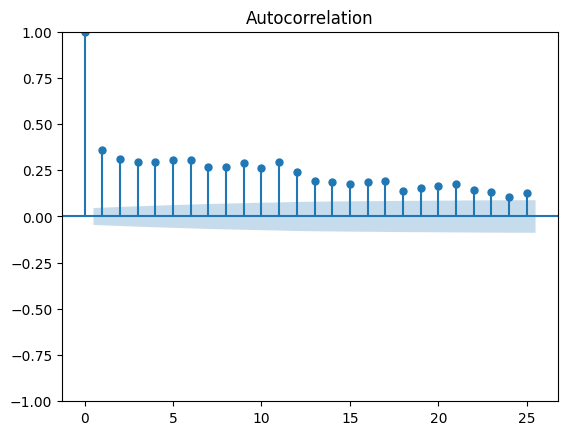

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(kurunegala_data["HCHO reading"], lags=25)
acf = plot_acf(kurunegala_data["HCHO reading"], lags=25)  

#### There is a seasonality in the Kurunegala data set

#### Kurunegala LSTM

In [19]:
data = pd.read_csv("../NullValueHandled/KurunegalaProperHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [20]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000088
1   2019-01-02      0.000137
2   2019-01-03      0.000148
3   2019-01-04     -0.000002
4   2019-01-05      0.000249


In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Assuming 'data' is your DataFrame and you've loaded it successfully

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length]) 
    return np.array(X), np.array(y) 

sequence_length = 5
# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)
 
model = Sequential([
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=400, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=10)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.005) 
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
37/37 [==============================] - 84s 842ms/step - loss: 0.9823 - mean_squared_error: 0.9823 - val_loss: 0.7231 - val_mean_squared_error: 0.7231
Epoch 2/100
37/37 [==============================] - 15s 400ms/step - loss: 0.8821 - mean_squared_error: 0.8821 - val_loss: 0.7713 - val_mean_squared_error: 0.7713
Epoch 3/100
37/37 [==============================] - 14s 364ms/step - loss: 0.8587 - mean_squared_error: 0.8587 - val_loss: 0.7486 - val_mean_squared_error: 0.7486
Epoch 4/100
37/37 [==============================] - 21s 561ms/step - loss: 0.8567 - mean_squared_error: 0.8567 - val_loss: 0.7961 - val_mean_squared_error: 0.7961
Epoch 5/100
37/37 [==============================] - 21s 557ms/step - loss: 0.8287 - mean_squared_error: 0.8287 - val_loss: 0.6886 - val_mean_squared_error: 0.6886
Epoch 6/100
37/37 [==============================] - 14s 380ms/step - loss: 0.8254 - mean_squared_error: 0.8254 - val_loss: 0.7524 - val_mean_squared_error: 0.7524
Epoch 7/100
37/3

Epoch 51/100
37/37 [==============================] - 4s 121ms/step - loss: 0.7307 - mean_squared_error: 0.7307 - val_loss: 0.7365 - val_mean_squared_error: 0.7365
Epoch 52/100
37/37 [==============================] - 5s 129ms/step - loss: 0.7310 - mean_squared_error: 0.7310 - val_loss: 0.7144 - val_mean_squared_error: 0.7144
Epoch 53/100
37/37 [==============================] - 4s 120ms/step - loss: 0.7195 - mean_squared_error: 0.7195 - val_loss: 0.7407 - val_mean_squared_error: 0.7407
Epoch 54/100
37/37 [==============================] - 4s 116ms/step - loss: 0.7290 - mean_squared_error: 0.7290 - val_loss: 0.7516 - val_mean_squared_error: 0.7516
Epoch 55/100
37/37 [==============================] - 4s 116ms/step - loss: 0.7011 - mean_squared_error: 0.7011 - val_loss: 0.7449 - val_mean_squared_error: 0.7449
Epoch 56/100
37/37 [==============================] - 5s 124ms/step - loss: 0.7065 - mean_squared_error: 0.7065 - val_loss: 0.7906 - val_mean_squared_error: 0.7906
Epoch 57/100
37/

12/12 [==============================] - 5s 35ms/step


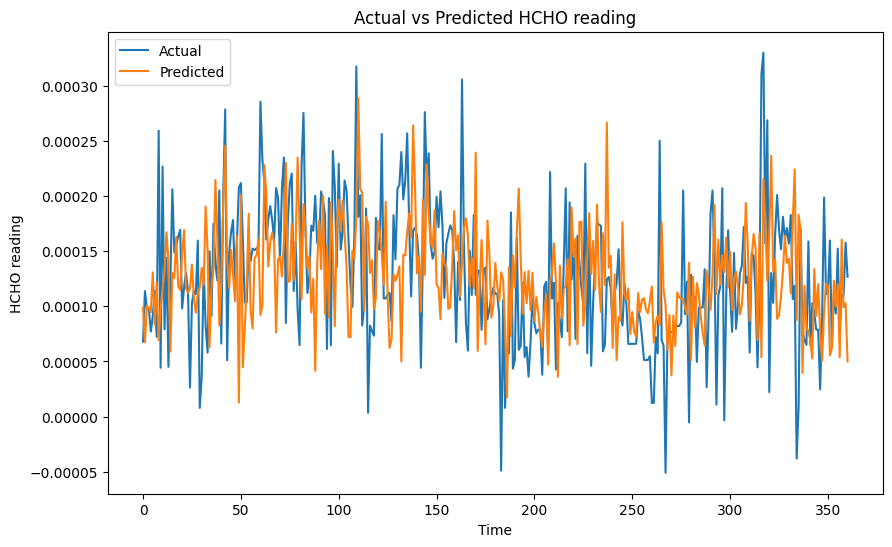

In [22]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 1s 32ms/step


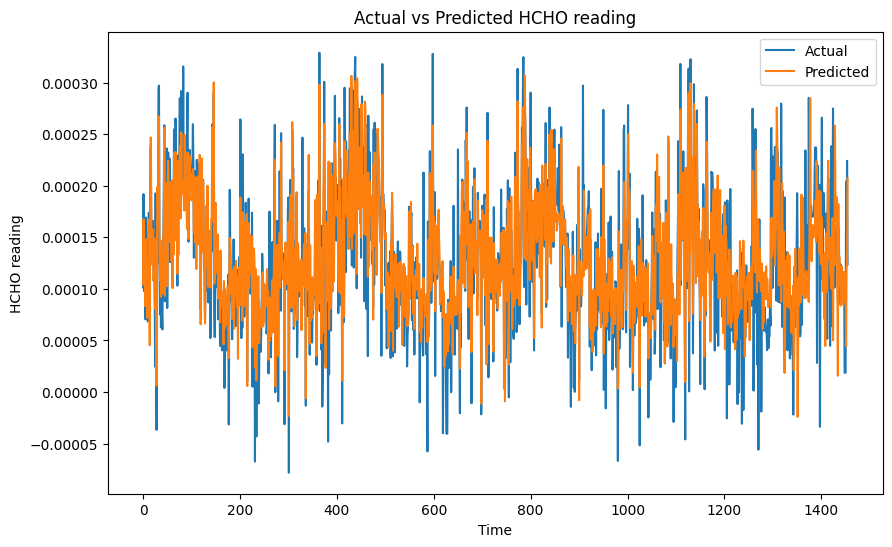

In [23]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 1s 31ms/step


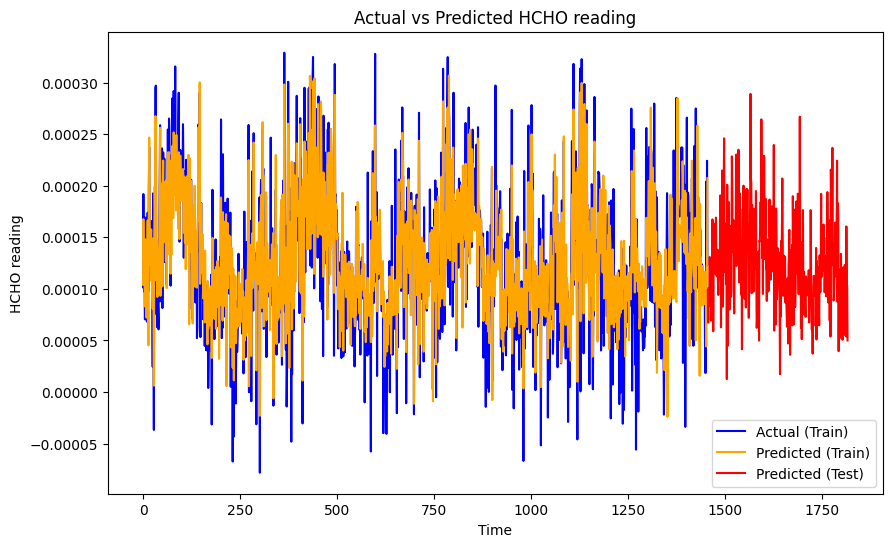

In [24]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

#### Model Testing Scores

In [25]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.6443692206090519
Mean Absolute Error (MAE): 2.8479143137776713e-05
Mean Squared Error (MSE): 1.6546962253276127e-09
Root Mean Squared Error (RMSE): 4.067795748716512e-05
Median Absolute Error: 1.9996354830906156e-05
Explained Variance Score: 0.6456126878718855


00:08:29 - cmdstanpy - INFO - Chain [1] start processing
00:08:29 - cmdstanpy - INFO - Chain [1] done processing


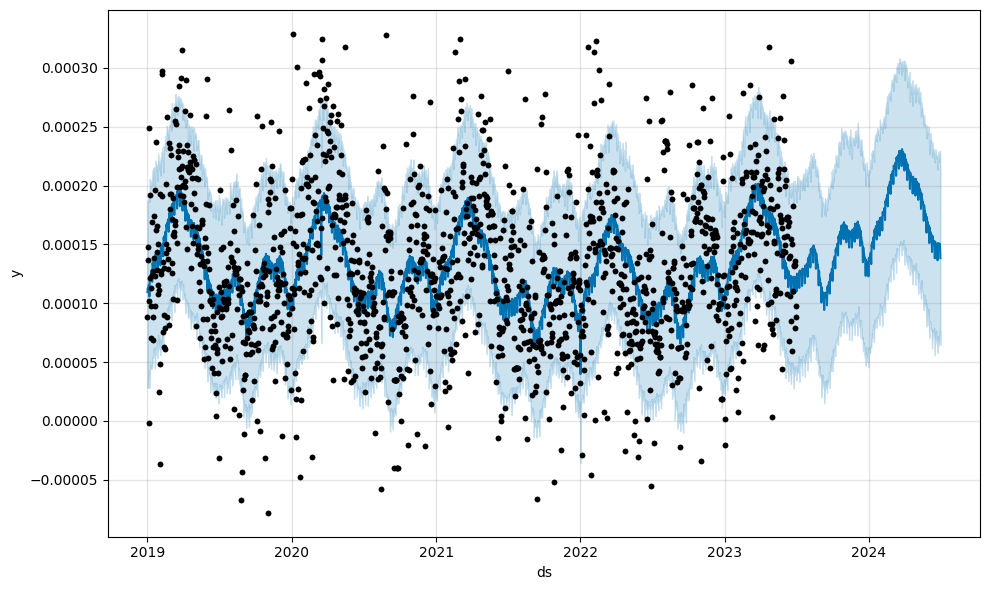

In [109]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/KurunegalaProperHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.90 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays,
               changepoint_prior_scale=0.3, 
               seasonality_prior_scale=5,) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()

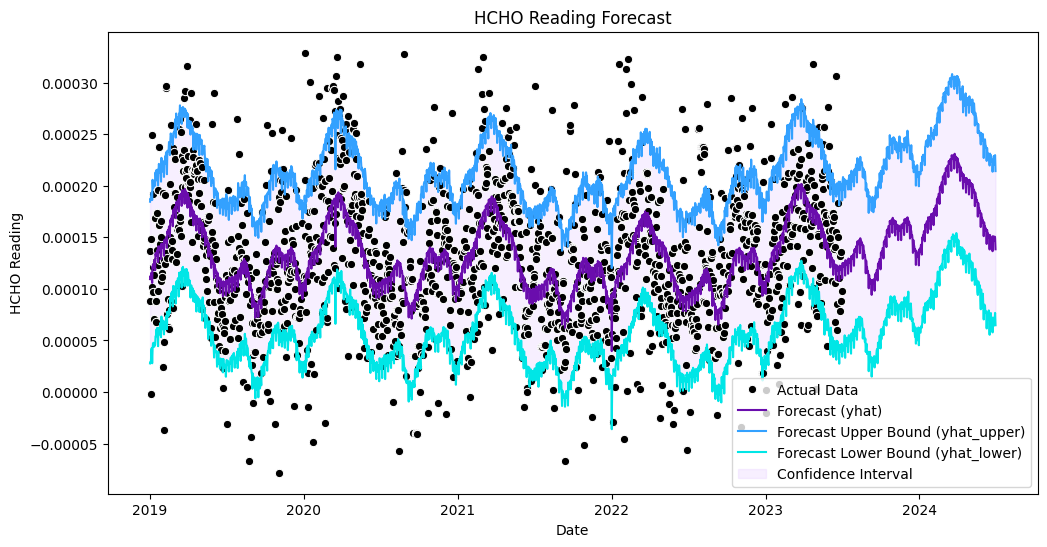

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual data
sns.lineplot(data=train_data, x='ds', y='y', label='Actual Data', color='black', marker='o', linestyle='None')

# Plot yhat - forecast
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast (yhat)', color='#6a0dad')  # Purple

# Plot yhat_upper
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Forecast Upper Bound (yhat_upper)', color='#33a1ff')  # Teal

# Plot yhat_lower
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Forecast Lower Bound (yhat_lower)', color='#00e6e6')  # Light Teal

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#d9b3ff', alpha=0.2, label='Confidence Interval')  # Light Purple

plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('HCHO Reading Forecast')

# Adjust legend
plt.legend()

plt.show()

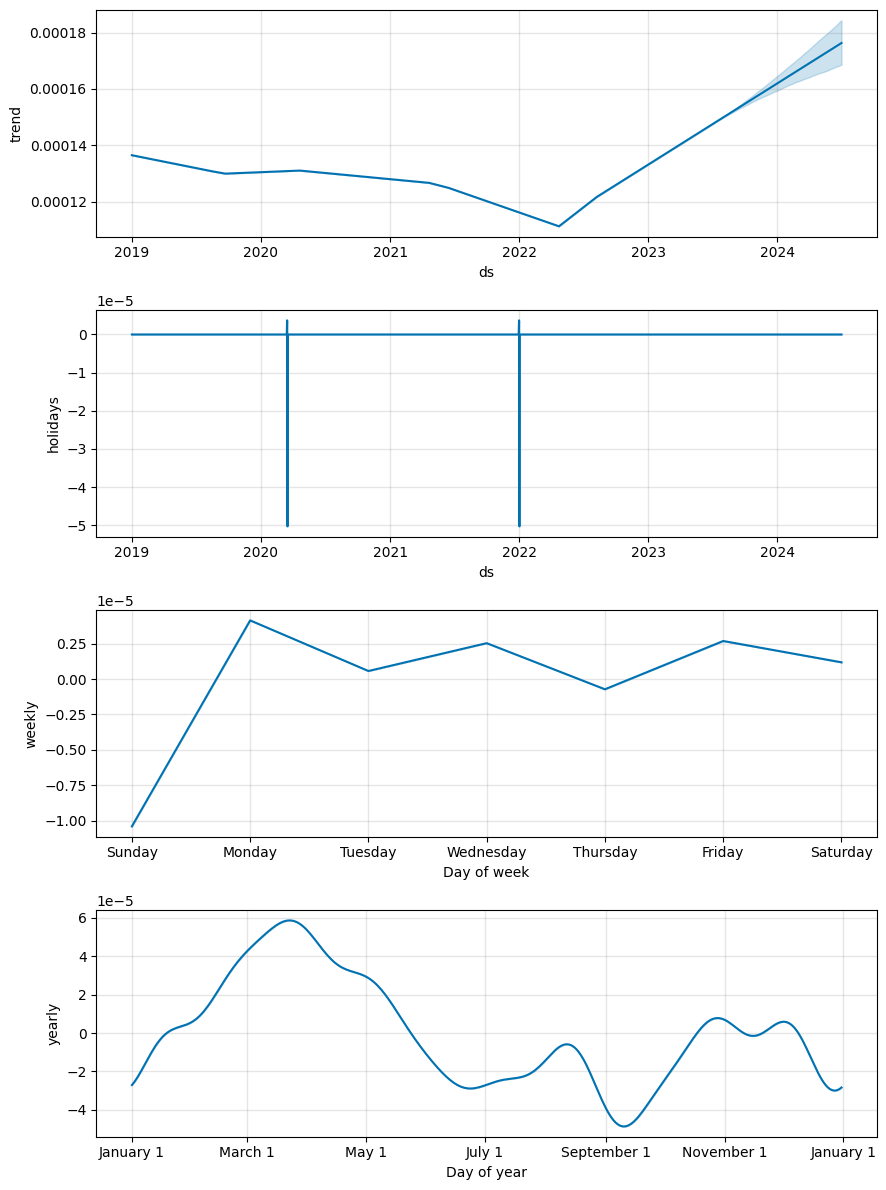

In [111]:
# Plot the forecast components
fig2 = model.plot_components(forecast)

In [112]:
y_test = test_data['y']
predicted_values = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat']  # Extract forecasted values for test period
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): -0.25792078454468204
Mean Absolute Error (MAE): 5.181082567927416e-05
Mean Squared Error (MSE): 4.260705314001012e-09
Root Mean Squared Error (RMSE): 6.527407842322259e-05
Median Absolute Error: 4.708687601755261e-05
Explained Variance Score: 0.07048579003635203


#### Kurunegala Multi Variate Model

In [102]:
data = pd.read_csv("../AnalysedFinalData/kurunegalaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Current Date          1826 non-null   object 
 1   HCHO reading          1826 non-null   float64
 2   Region                1826 non-null   object 
 3   LATITUDE              1826 non-null   float64
 4   LONGITUDE             1826 non-null   float64
 5   ELEVATION             1826 non-null   float64
 6   PRCP                  1826 non-null   float64
 7   TAVG                  1826 non-null   float64
 8   TMAX                  1826 non-null   float64
 9   TMIN                  1826 non-null   float64
 10  Population            1826 non-null   int64  
 11  Area_sq_km            1826 non-null   int64  
 12  population_density    1826 non-null   float64
 13  Proximity(km)         1826 non-null   float64
 14  carbon_monoxide       1826 non-null   float64
 15  nitogen_dioxide      

In [104]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [105]:
data.head()

,Current Date,HCHO reading,Region,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN,Population,Area_sq_km,population_density,Proximity(km),carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000088,Kurunegala Proper,7.467,80.367,116.0,0.0,78.0,87.0,72.0,1719000,4816,356.94,59.5,0.035947,0.000007,0.115939,0,0,Before,Before
1,2019-01-02,0.000137,Kurunegala Proper,7.467,80.367,116.0,0.0,78.0,87.0,72.0,1719000,4816,356.94,59.5,0.036163,0.000011,0.115939,0,0,Before,Before
2,2019-01-03,0.000148,Kurunegala Proper,7.467,80.367,116.0,0.0,81.0,87.0,71.0,1719000,4816,356.94,59.5,0.032443,0.000010,0.115939,0,0,Before,Before
3,2019-01-04,-0.000002,Kurunegala Proper,7.467,80.367,116.0,0.0,83.0,88.0,69.0,1719000,4816,356.94,59.5,0.034312,0.000009,0.115939,0,0,Before,Before
4,2019-01-05,0.000249,Kurunegala Proper,7.467,80.367,116.0,0.0,84.0,90.0,65.0,1719000,4816,356.94,59.5,0.033251,0.000009,0.115939,0,0,Before,Before


#### remove constant data

In [106]:
data.columns

Index(['Current Date', 'HCHO reading', 'Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'Population', 'Area_sq_km',
       'population_density', 'Proximity(km)', 'carbon_monoxide',
       'nitogen_dioxide', 'ozone', 'new_covid_patients',
       'total_covid_patients', 'lockdown_status', 'covid_range_status'],
      dtype='object')

In [107]:
data.drop(columns=['Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION','Area_sq_km', 'Proximity(km)'], inplace=True)

In [108]:
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000088,0.0,78.0,87.0,72.0,1719000,356.94,0.035947,0.000007,0.115939,0,0,Before,Before
1,2019-01-02,0.000137,0.0,78.0,87.0,72.0,1719000,356.94,0.036163,0.000011,0.115939,0,0,Before,Before
2,2019-01-03,0.000148,0.0,81.0,87.0,71.0,1719000,356.94,0.032443,0.000010,0.115939,0,0,Before,Before
3,2019-01-04,-0.000002,0.0,83.0,88.0,69.0,1719000,356.94,0.034312,0.000009,0.115939,0,0,Before,Before
4,2019-01-05,0.000249,0.0,84.0,90.0,65.0,1719000,356.94,0.033251,0.000009,0.115939,0,0,Before,Before


#### Encode Categorical data

In [109]:
from sklearn.preprocessing import LabelEncoder
 
dates = data["Current Date"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in the DataFrame
for column in data.columns:
    # Check if the column is of categorical type
    if data[column].dtype == 'object':
        # Fit label encoder and transform values
        data[column] = label_encoder.fit_transform(data[column])

In [110]:
data["Current Date"] = dates
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000088,0.0,78.0,87.0,72.0,1719000,356.94,0.035947,0.000007,0.115939,0,0,1,1
1,2019-01-02,0.000137,0.0,78.0,87.0,72.0,1719000,356.94,0.036163,0.000011,0.115939,0,0,1,1
2,2019-01-03,0.000148,0.0,81.0,87.0,71.0,1719000,356.94,0.032443,0.000010,0.115939,0,0,1,1
3,2019-01-04,-0.000002,0.0,83.0,88.0,69.0,1719000,356.94,0.034312,0.000009,0.115939,0,0,1,1
4,2019-01-05,0.000249,0.0,84.0,90.0,65.0,1719000,356.94,0.033251,0.000009,0.115939,0,0,1,1


#### Check correlations

In [116]:
corr = data.corr(numeric_only=True)["HCHO reading"]
corr = pd.DataFrame(corr)
corr = corr.T
corr

,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
HCHO reading,1.0,-0.020175,0.174568,0.342388,-0.095334,-0.037514,-0.037528,0.276864,0.007006,-0.075194,-0.057518,-0.074258,0.037139,0.018257


In [117]:
corr.to_csv("../OtherData/KurunegalaCorrelationData.csv")

In [80]:
data.shape

(1826, 15)

#### remove covid range status

In [81]:
data.drop(columns=["covid_range_status"], inplace=True)

#### Devide X and Y

In [82]:
X = data.drop(columns=["HCHO reading"])
y = data["HCHO reading"]

In [83]:
X.head()

,Current Date,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status
0,2019-01-01,0.0,78.0,87.0,72.0,1719000,356.94,0.035947,0.000007,0.115939,0,0,1
1,2019-01-02,0.0,78.0,87.0,72.0,1719000,356.94,0.036163,0.000011,0.115939,0,0,1
2,2019-01-03,0.0,81.0,87.0,71.0,1719000,356.94,0.032443,0.000010,0.115939,0,0,1
3,2019-01-04,0.0,83.0,88.0,69.0,1719000,356.94,0.034312,0.000009,0.115939,0,0,1
4,2019-01-05,0.0,84.0,90.0,65.0,1719000,356.94,0.033251,0.000009,0.115939,0,0,1


#### Select features based on Correlations

In [84]:
data.corr(numeric_only=True)["HCHO reading"]

HCHO reading            1.000000
PRCP                   -0.020175
TAVG                    0.174568
TMAX                    0.342388
TMIN                   -0.095334
Population             -0.037514
population_density     -0.037528
carbon_monoxide         0.276864
nitogen_dioxide         0.007006
ozone                  -0.075194
new_covid_patients     -0.057518
total_covid_patients   -0.074258
lockdown_status         0.037139
Name: HCHO reading, dtype: float64

In [85]:
X = X[["Current Date", "carbon_monoxide","TMAX"]]
X.head() 

,Current Date,carbon_monoxide,TMAX
0,2019-01-01,0.035947,87.0
1,2019-01-02,0.036163,87.0
2,2019-01-03,0.032443,87.0
3,2019-01-04,0.034312,88.0
4,2019-01-05,0.033251,90.0


In [86]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Current Date     1826 non-null   object 
 1   carbon_monoxide  1826 non-null   float64
 2   TMAX             1826 non-null   float64
dtypes: float64(2), object(1)
memory usage: 42.9+ KB


#### Standardize, variable data

In [87]:
from sklearn.preprocessing import StandardScaler
# Select columns of interest
selected_columns = ["carbon_monoxide","TMAX"]

# Convert "Current Date" to datetime format
data["Current Date"] = pd.to_datetime(data["Current Date"])

# Separate the "Current Date" column
current_date = data["Current Date"]

# Select only the columns you're interested in for standardization
X = X[selected_columns]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the data
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_columns)

# Concatenate "Current Date" column with the scaled data
X = pd.concat([current_date, X_scaled_df], axis=1)

X.set_index("Current Date", inplace=True)

In [88]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carbon_monoxide  1826 non-null   float64
 1   TMAX             1826 non-null   float64
dtypes: float64(2)
memory usage: 42.8 KB


##### Standardize target variable

In [89]:
y = data['HCHO reading']

y.head()

0    0.000088
1    0.000137
2    0.000148
3   -0.000002
4    0.000249
Name: HCHO reading, dtype: float64

In [90]:
from sklearn.preprocessing import MinMaxScaler
scaler_y = MinMaxScaler()
y_scaled = np.array(scaler_y.fit_transform(y.values.reshape(-1, 1)), ndmin=1)

In [91]:
X_scaled = X

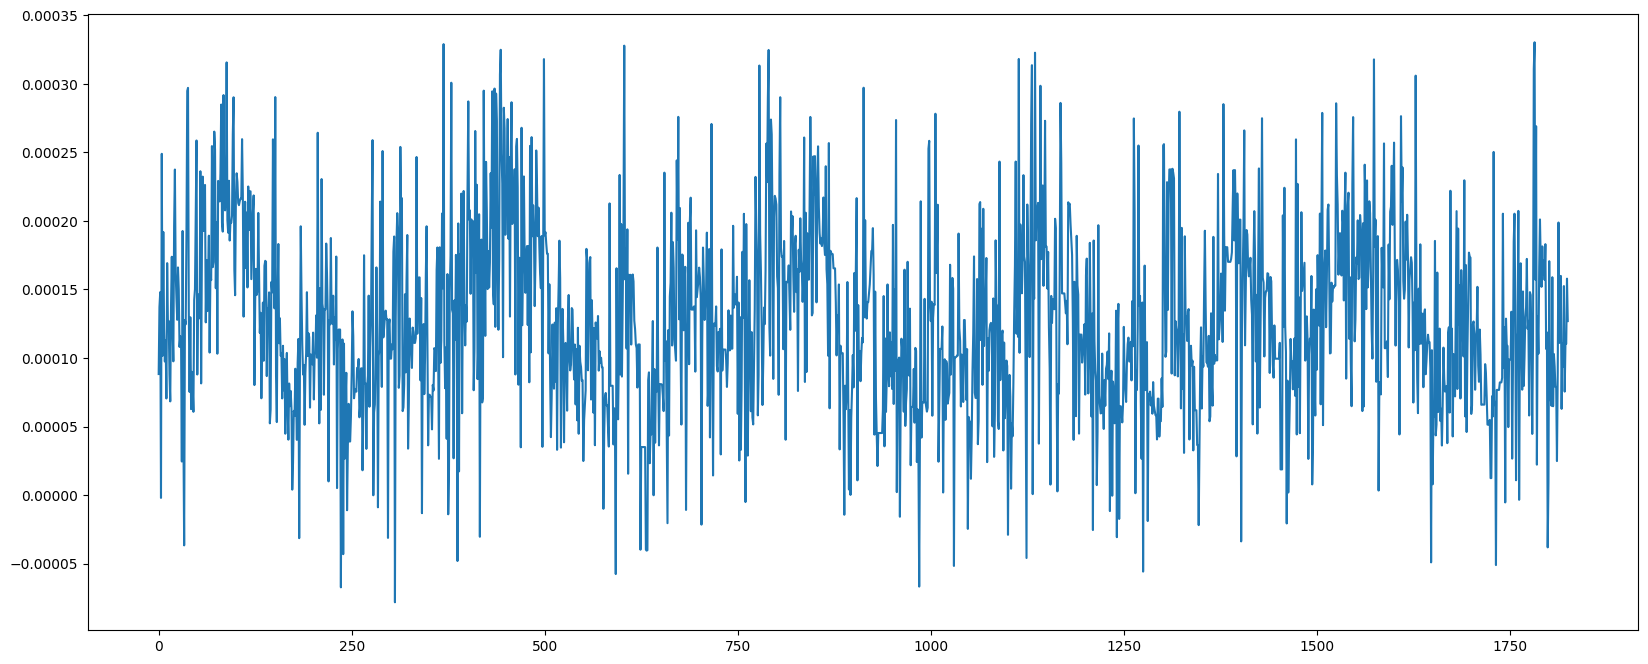

In [92]:
plt.figure(figsize=(20, 8))
plt.plot(scaler_y.inverse_transform(y_scaled))

In [93]:
print(X_scaled.head())

              carbon_monoxide      TMAX
Current Date                           
2019-01-01           0.781534 -0.851669
2019-01-02           0.815476 -0.851669
2019-01-03           0.231763 -0.851669
2019-01-04           0.525000 -0.591436
2019-01-05           0.358602 -0.070972


#### Apply multivariate time series model

In [98]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanAbsoluteError


# Now, split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X_scaled) * split_ratio)

X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]


model = Sequential([
    Bidirectional(LSTM(units=120, return_sequences=True, activation="relu"), input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    Bidirectional(LSTM(units=5)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

# Compilation of the model
optimizer = Adam(learning_rate=0.008)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/150
46/46 [==============================] - 10s 48ms/step - loss: 0.0504 - mean_squared_error: 0.0504 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 2/150
46/46 [==============================] - 1s 11ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 3/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 4/150
46/46 [==============================] - 0s 11ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 5/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 6/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 7/150
46/46 [========

46/46 [==============================] - 0s 10ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 52/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 53/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 54/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 55/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 56/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 57/150
46/46 [===============

46/46 [==============================] - 0s 10ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 102/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 103/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 104/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 105/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 106/150
46/46 [==============================] - 0s 11ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 107/150
46/46 [=========

12/12 [==============================] - 0s 6ms/step - loss: 0.0204 - mean_squared_error: 0.0204
Test Loss: [0.02039891481399536, 0.02039891481399536]
12/12 [==============================] - 2s 4ms/step


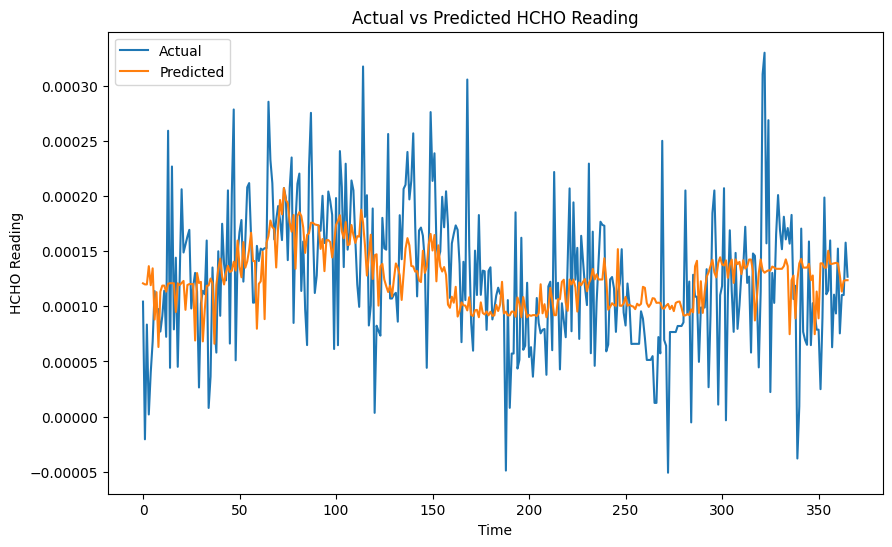

In [99]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)

# Optionally, you can inverse transform the predictions to get them back to the original scale
predictions_inv = scaler_y.inverse_transform(predictions)
actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO Reading')
plt.title('Actual vs Predicted HCHO Reading')
plt.legend()
plt.show()

46/46 [==============================] - 0s 4ms/step


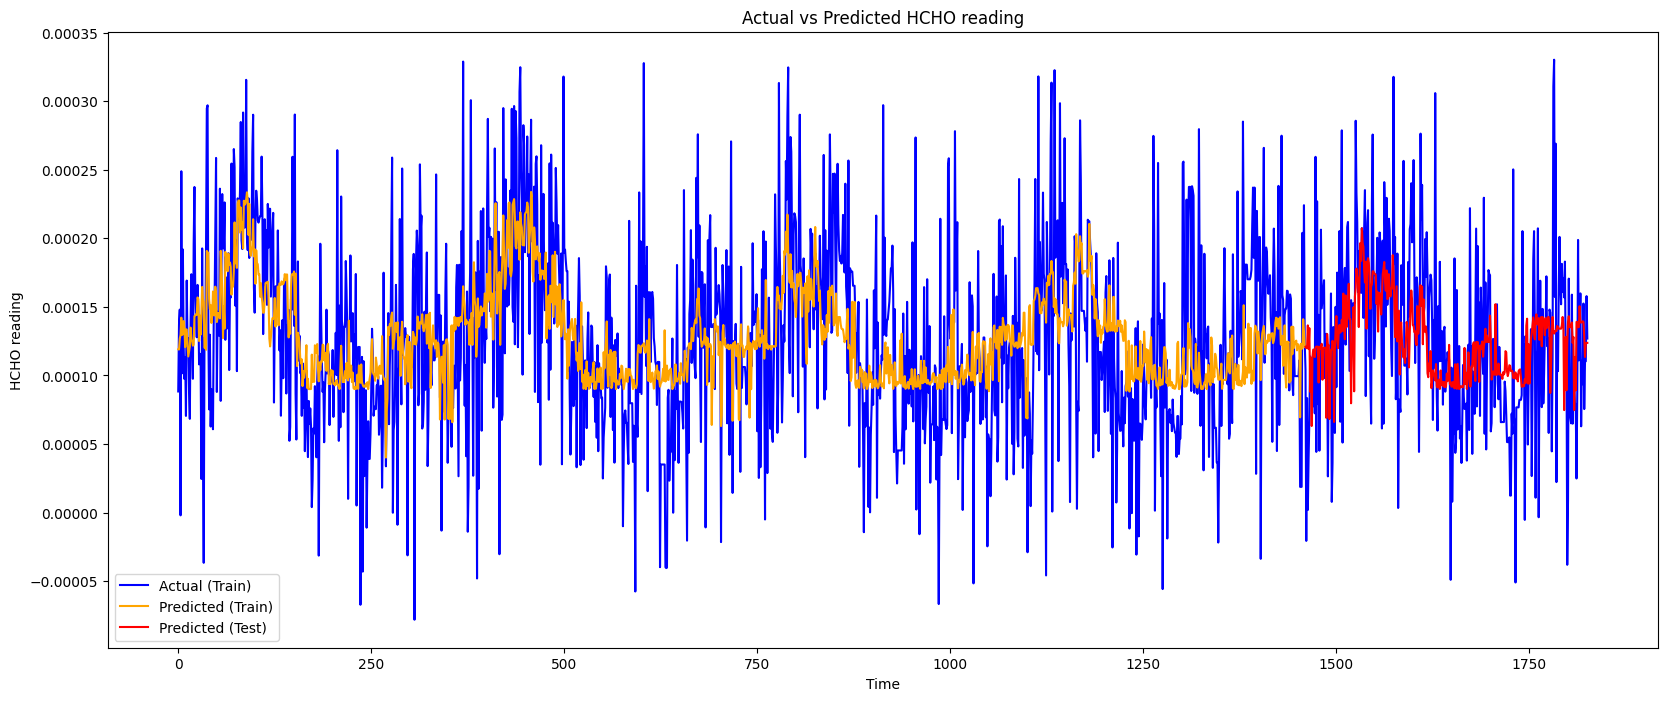

In [100]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler_y.inverse_transform(predictions)
actual_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler_y.inverse_transform(predictions_scaled_train)
actual_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(20, 8))
plt.plot(data["HCHO reading"], label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [118]:
r2 = (r2_score(actual_test, predictions_test))
mae = mean_absolute_error(actual_test, predictions_test)
mse = mean_squared_error(actual_test, predictions_test) 
rmse = mean_squared_error(actual_test, predictions_test, squared=False)
median_absolute = median_absolute_error(actual_test,predictions_test)
explained_variance = explained_variance_score(actual_test, predictions_test)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.14525245969916867
Mean Absolute Error (MAE): 4.565564405339549e-05
Mean Squared Error (MSE): 3.4029150011986713e-09
Root Mean Squared Error (RMSE): 5.833450952222596e-05
Median Absolute Error: 3.737363357035195e-05
Explained Variance Score: 0.14550660384496106
